
# Autoencoder

In this notebook, you will implement an autoencoder. An autoencoder seeks to learn a latent representation of our training images by using unlabeled data and learning to reconstruct its inputs.

In [19]:
# DO NOT MODIFY THIS CELL!
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from visualize_util import visualize_img_batch, plot_latent_space, plot_latent_space_images


In [20]:
def visualize_img_batch(image_batch): # shape of the image batch should be (N, H, W)
    img_num, H, W = image_batch.shape
    vis_w = 10
    vis_h = int(np.ceil(img_num/10))

    padded_img_num = vis_w*vis_h
    
    if padded_img_num != img_num:
        empty_img_num = padded_img_num - img_num
        padded_image_batch = np.concatenate([image_batch, np.ones( (empty_img_num, H, W))], axis = 0 )
    else:
        padded_image_batch = image_batch
    
    padded_image_batch = np.stack([np.pad(img,(1,1), 'constant', constant_values=(1,1)) for img in padded_image_batch], axis = 0) 
    padded_image_batch = np.reshape(padded_image_batch, (vis_h, vis_w, H+2, W+2 ))
    padded_image_batch = np.concatenate( padded_image_batch, axis=1)
    padded_image_batch = np.concatenate( padded_image_batch, axis=1)
    
    fig = plt.figure(figsize=(vis_w,vis_h))
    plt.imshow(padded_image_batch, cmap='gray')
    plt.axis('off')

def plot_latent_space_images(decoder, device, zi_range = np.arange(-5,5), zj_range = np.arange(5,-5,-1)):
    zi, zj = np.meshgrid(zi_range,zj_range)
    z = np.stack( [ zi.reshape(-1), zj.reshape(-1)], axis = 1)
    z = torch.Tensor(z).to(device)
    z=z.reshape(-1,1,2)
    x_hat = decoder(z).detach().cpu().numpy().squeeze()
    visualize_img_batch(x_hat)

In [2]:
# Use this if you are using any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
# Use this only if you are running on M1/M2 macbooks
# dtype = torch.float
# device = torch.device("mps")

## Load MNIST Dataset


We will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9).

We will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `data`. 

In [6]:
#TODO
hidden_dim = 400 
latent_dim = 2 
batch_size = 50 
n_epochs = 15 

transform = transforms.ToTensor() # TODO, convert data to torch.FloatTensor
mnist_train = datasets.MNIST('./data', 
               transform=transform, 
               download=True, train=True)

loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

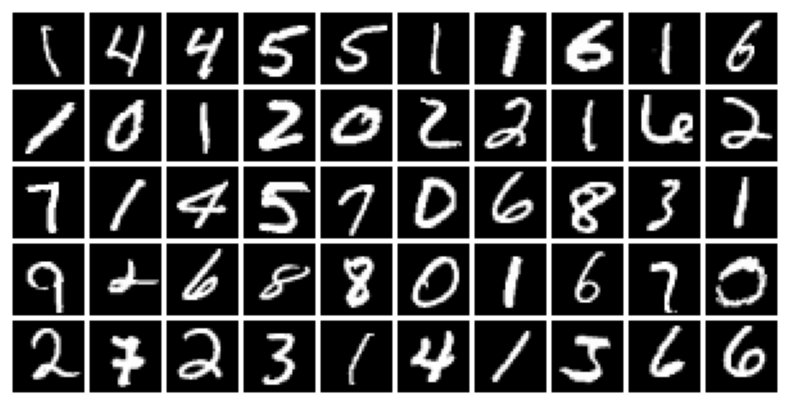

In [7]:
imgs = next(iter(loader_train))[0].numpy().squeeze()
visualize_img_batch(imgs)

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim,hidden_dim,input_dim):
        super(Autoencoder, self).__init__()
        self.output_dim = input_dim
        self.input_dim=input_dim
        self.latent_dim=latent_dim
        self.hidden_dim=hidden_dim
        #TODO
        self.encoder = nn.Sequential(nn.Flatten(2,3),
                                     nn.Linear(self.input_dim,self.hidden_dim),
                                     nn.LeakyReLU(),
                                     nn.Linear(self.hidden_dim,self.hidden_dim),
                                     nn.LeakyReLU(),
                                     nn.Linear(self.hidden_dim,self.latent_dim))
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim,self.hidden_dim),
                                     nn.LeakyReLU(),
                                     nn.Linear(self.hidden_dim,self.hidden_dim),
                                     nn.LeakyReLU(),
                                     nn.Linear(self.hidden_dim,self.output_dim),
                                     nn.Sigmoid(),
                                     nn.Unflatten(2,(28,28)))

    def forward(self, x):
        encoder_out=self.encoder(x)
        decoder_out= self.decoder(encoder_out)
        return decoder_out

In [23]:
from torchsummary import summary
autoencoder = Autoencoder(latent_dim, hidden_dim,784).to(device)
summary(autoencoder,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1               [-1, 1, 784]               0
            Linear-2               [-1, 1, 400]         314,000
         LeakyReLU-3               [-1, 1, 400]               0
            Linear-4               [-1, 1, 400]         160,400
         LeakyReLU-5               [-1, 1, 400]               0
            Linear-6                 [-1, 1, 2]             802
            Linear-7               [-1, 1, 400]           1,200
         LeakyReLU-8               [-1, 1, 400]               0
            Linear-9               [-1, 1, 400]         160,400
        LeakyReLU-10               [-1, 1, 400]               0
           Linear-11               [-1, 1, 784]         314,384
          Sigmoid-12               [-1, 1, 784]               0
        Unflatten-13            [-1, 1, 28, 28]               0
Total params: 951,186
Trainable params:

In [24]:
criterion = nn.MSELoss() # TODO: specify loss function
optimizer = torch.optim.Adam(autoencoder.parameters(),lr=0.001) # TODO: specify optimizer
loss_history=[]
for epoch in range(n_epochs):
    train_loss = 0
    for x, y in loader_train:
        #TODO
        optimizer.zero_grad()# clear the gradients of all optimized variables
        out=autoencoder(x)# forward pass:
        l=criterion(out,x)# calculate the loss using the criterion defined above
        l.backward()# backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()# perform a single optimization step (parameter update)
        train_loss+=l# update running training loss

    train_loss = train_loss/len(loader_train)
    loss_history.append(train_loss.item())
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 0.048654
Epoch: 1 	Training Loss: 0.041500
Epoch: 2 	Training Loss: 0.039930
Epoch: 3 	Training Loss: 0.039073
Epoch: 4 	Training Loss: 0.038483
Epoch: 5 	Training Loss: 0.037691
Epoch: 6 	Training Loss: 0.037263
Epoch: 7 	Training Loss: 0.037025
Epoch: 8 	Training Loss: 0.036601
Epoch: 9 	Training Loss: 0.036599
Epoch: 10 	Training Loss: 0.036367
Epoch: 11 	Training Loss: 0.036312
Epoch: 12 	Training Loss: 0.035948
Epoch: 13 	Training Loss: 0.035902
Epoch: 14 	Training Loss: 0.035858


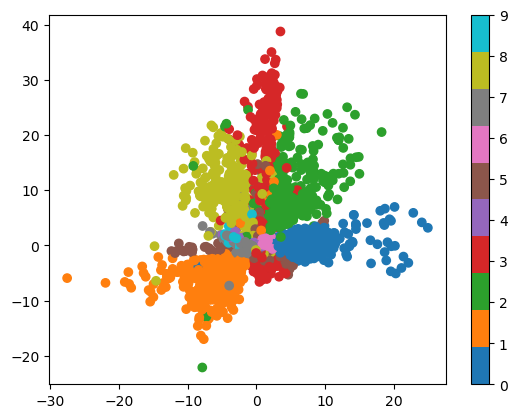

In [25]:
# show latent space distribution
plot_latent_space(autoencoder.encoder, loader_train, device)

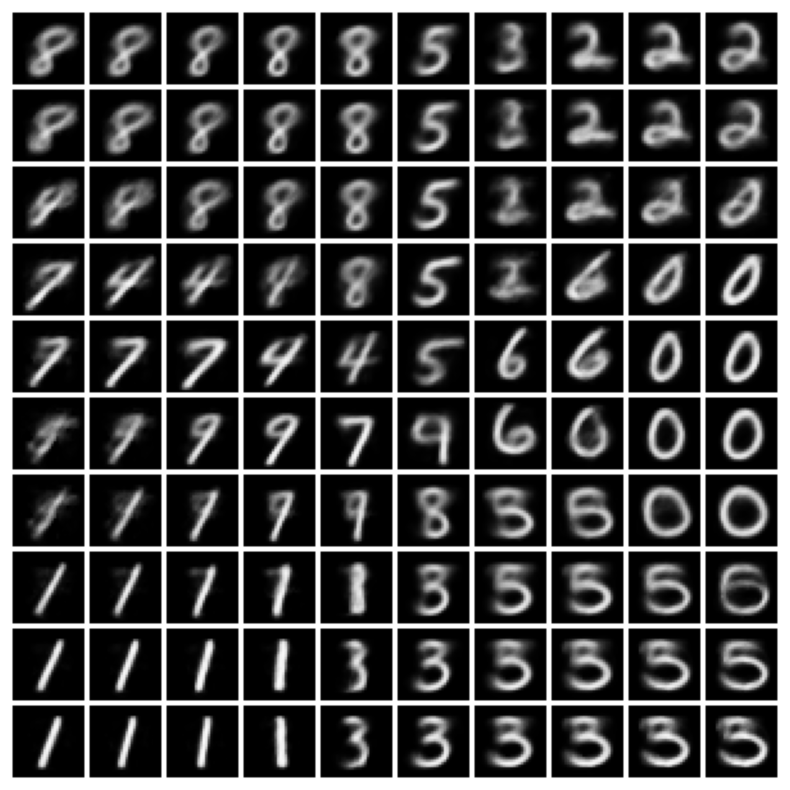

In [26]:
# show reconstruction from latent space images
plot_latent_space_images(autoencoder.decoder, device)

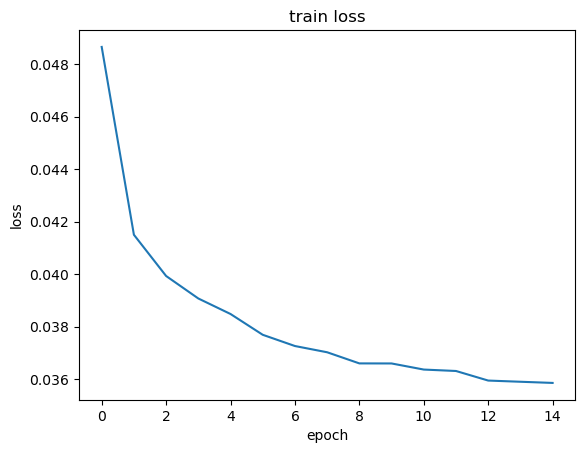

In [28]:
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('train loss')
plt.show()